In [23]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


In [29]:
# Config
npy_dir = "../LabelData/data/"
csv_out = "../LabelData/labels.csv"
X_out = "../LabelData/X.npy"
Y_out = "../LabelData/Y.npy"
min_valid_bands = 4  # Minimum # finite values required to keep sample

# CSV Header
header = ["filename", "label", "latitude", "longitude", "date", "valid_band_count"]

# Containers
X = []
Y = []
meta = []

# Iterate over .npy files
for fname in sorted(os.listdir(npy_dir)):
    if not fname.endswith(".npy"):
        continue

    path = os.path.join(npy_dir, fname)

    # Parse metadata from filename
    try:
        label_str, lat_str, lon_str, date_str = fname[:-4].split("_")
        lat = float(lat_str)
        lon = float(lon_str)
    except Exception as e:
        print(f"[WARNING] Skipping {fname}: bad filename format → {e}")
        continue

    try:
        data = np.load(path, allow_pickle=True).item()
        label = int(data.get("algae_class", -1))
        Rrs = data.get("Rrs_mean")

        if Rrs is None or not isinstance(Rrs, np.ndarray):
            raise ValueError("Missing or invalid Rrs_mean")

        valid_count = np.isfinite(Rrs).sum()

        if valid_count < min_valid_bands:
            continue  # skip this sample

        # Normalize Rrs shape and replace NaNs with 0 or keep as-is
        Rrs_clean = np.where(np.isfinite(Rrs), Rrs, 0.0)  # You can change to NaN if preferred

        # One-hot encode label
        one_hot = [1, 0] if label == 0 else [0, 1]

        # Append
        X.append(Rrs_clean)
        Y.append(one_hot)
        meta.append([fname, label, lat, lon, date_str, int(valid_count)])

    except Exception as e:
        print(f"[ERROR] Failed to load/process {fname}: {e}")

# Convert and save
X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.int32)

np.save(X_out, X)
np.save(Y_out, Y)

# Save metadata CSV
with open(csv_out, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(meta)

print(f"✅ Saved:")
print(f" - {X.shape[0]} samples to {X_out}")
print(f" - {Y.shape[0]} labels to {Y_out}")
print(f" - Metadata CSV to {csv_out}")

✅ Saved:
 - 151 samples to ../LabelData/X.npy
 - 151 labels to ../LabelData/Y.npy
 - Metadata CSV to ../LabelData/labels.csv


✅ Accuracy: 90.79%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        58
           1       0.87      0.72      0.79        18

    accuracy                           0.91        76
   macro avg       0.89      0.84      0.86        76
weighted avg       0.91      0.91      0.90        76



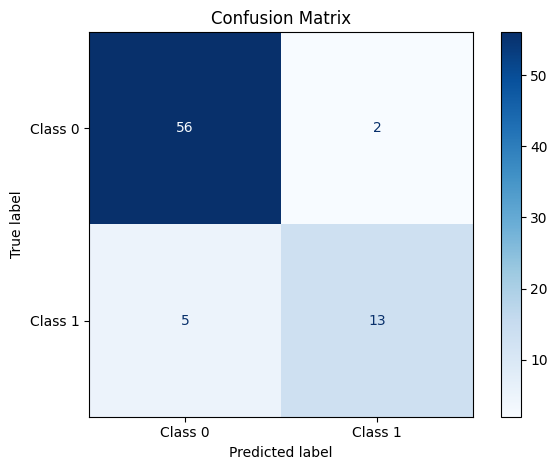

In [30]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Paths
X_path = "../LabelData/X.npy"
Y_path = "../LabelData/Y.npy"

# Load data
X = np.load(X_path)
Y = np.load(Y_path)

# Convert one-hot → class labels
y = np.argmax(Y, axis=1)  # shape (n_samples,)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

# Initialize Random Forest
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)

# Train
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


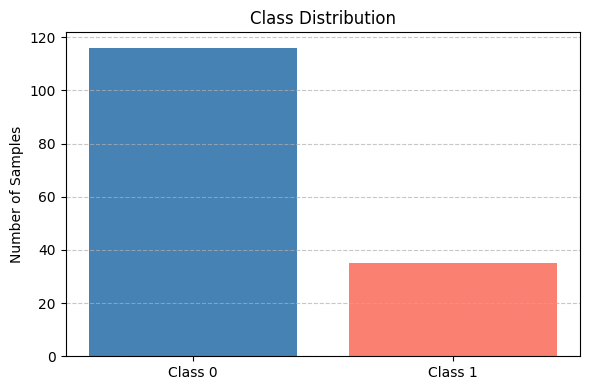